In [1]:
# imports
from sklearn.model_selection import train_test_split
from moduleDatabase import DatabaseMethods
from modulePreProcessing import ScalingMethods, FeatureMethods, boxplot_features
from moduleModelTraining import TrainingMethods
from moduleMetrics import MetricsMethods

# class instances
db = DatabaseMethods()
scale = ScalingMethods()
fm = FeatureMethods()
train = TrainingMethods()
evaluate = MetricsMethods()

# connect to db and fetch data
df = db.fetch("SELECT * FROM v7")
df.head()

# # present target classes by volume
# df_tcbs = db.fetch("")
# df_tcbs.head()
# test = pd.DataFrame({'MOCA Pre Bin 0-25' : [94, 24],
#                      'MOCA Pre Bin 26-30' : [24, 52]
#                     }, 
#                     {'1','2'})
# ax = test.plot.bar()

# define target class (14 available, 6 moca, 6 mmse, 2 diffs)
target_class = "moca_pre_binary_binned"
df = db.separate_target_class(df, target_class)

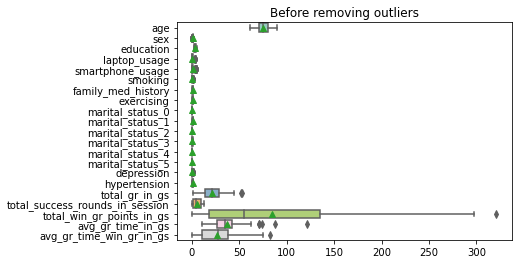

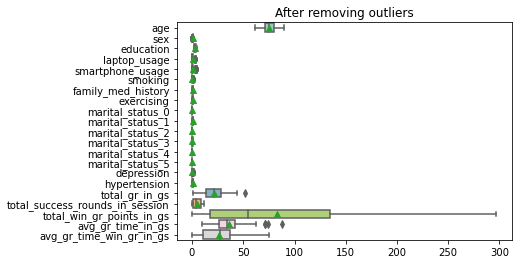

In [2]:
# We can't have outliers from 
# TODO show outliers not only before scaling but also before binning 
# handle outliers. The whole process should avoid outliers in the first place.
df = scale.handle_outliers(df)

In [3]:
# Encoding of categorical to numerical. 
# No need for that particular encoding, since we fetch their ids from the view.

In [4]:
# Discretize
columns_to_discretize = ['age','avg_gr_time_win_gr_in_gs', 'avg_gr_time_win_gr_in_gs', 'avg_gr_time_in_gs', 
                         'total_win_gr_points_in_gs', 'total_gr_in_gs', 'total_success_rounds_in_session']
fm.discretize_features(df, columns_to_discretize)

,userId,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,...,marital_status_4,marital_status_5,depression,hypertension,total_gr_in_gs,total_success_rounds_in_session,total_win_gr_points_in_gs,avg_gr_time_in_gs,avg_gr_time_win_gr_in_gs,target_class
gsId,,,,,,,,,,,,,,,,,,,,,
18245,23,18245,1560929400,1,1,4,0,0,0,1,...,0,0,0,0,0,1,1,0,1,1
76067,6,76067,1555499640,0,1,4,1,3,0,1,...,0,0,0,1,4,2,2,3,4,1
79781,8,79781,1557928260,4,1,5,1,1,0,0,...,0,0,0,0,1,2,1,3,4,1
180144,32,180144,1557315840,1,1,2,0,4,0,0,...,0,0,0,1,4,1,2,2,0,2
209758,24,209758,1560933840,3,1,2,0,0,0,1,...,0,0,0,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5654576,8,5654576,1558894440,4,1,5,1,1,0,0,...,0,0,0,0,4,3,4,0,3,1
5723404,4,5723404,1556711460,4,1,3,3,0,0,0,...,0,0,0,0,4,4,4,3,3,1
5751092,7,5751092,1560012840,3,0,4,0,0,0,0,...,0,0,1,1,4,4,4,3,4,1


,0
smartphone_usage,2.28
avg_gr_time_win_gr_in_gs,2.03
avg_gr_time_in_gs,2.03
total_win_gr_points_in_gs,2.02
total_gr_in_gs,1.95
total_success_rounds_in_session,1.91
age,1.90
education,1.06
laptop_usage,0.86
family_med_history,0.25


Threshold value:  0.16
Features ruled out: 
 ['sex', 'smoking', 'marital_status_0', 'marital_status_2', 'marital_status_4', 'marital_status_5', 'depression']


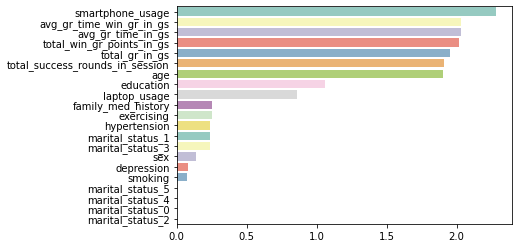

In [5]:
# remove low variance features. 
df = fm.remove_low_variance_features(df, (.8 * (1 - .8)), ddof_val=1)

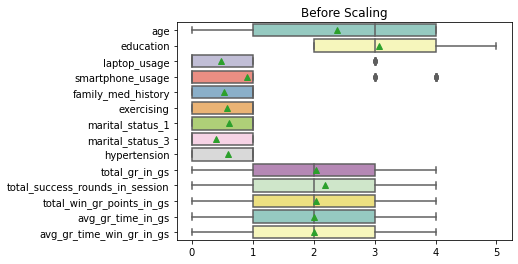

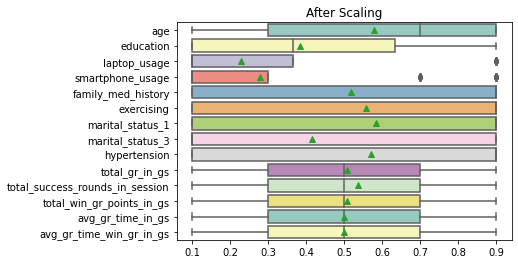

In [6]:
# scaling
columnsToIgnore = ['userId', 'gsId', 'gsStartTime', 'target_class']
df = scale.use_min_max(df, columnsToIgnore)

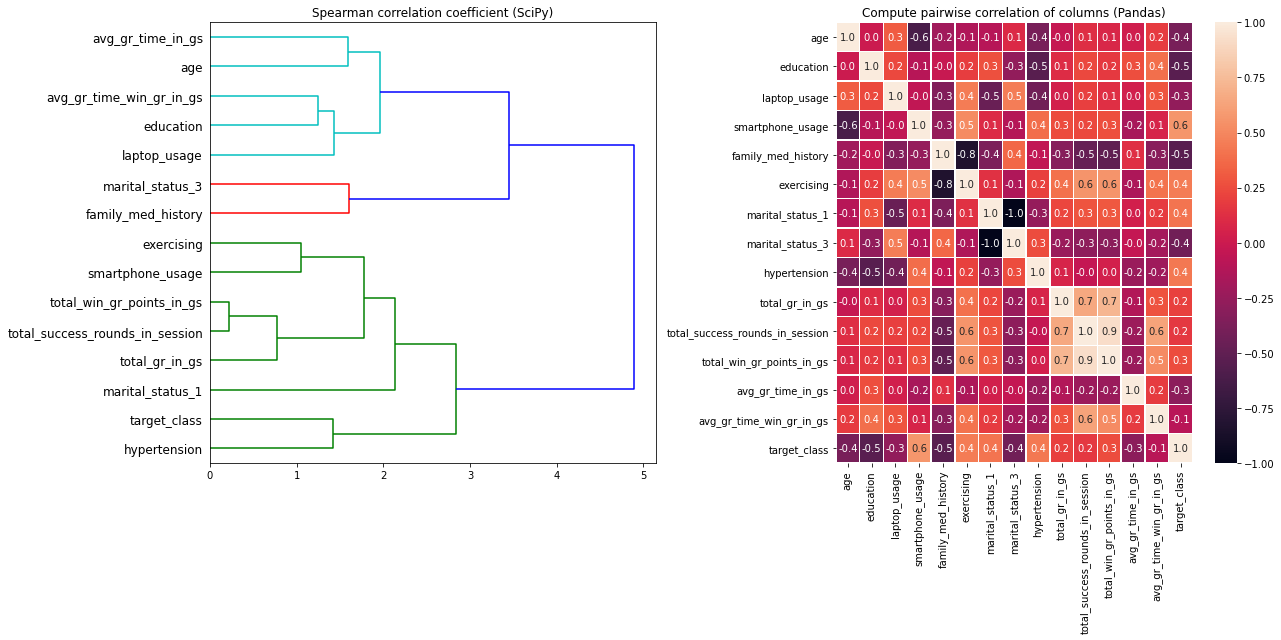

In [7]:
# feature correlation inspection. Select features correlated to target class not between them.
fs = ['age', 'education','laptop_usage', 'smartphone_usage', 'family_med_history', 'exercising', 'marital_status_1',
      'marital_status_3', 'hypertension', 'total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
      'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs', 'target_class']
fm.correlation_inspection(df, fs)

In [8]:
all_features = ['age', 'education','laptop_usage', 'smartphone_usage', 'family_med_history', 'exercising',
                'marital_status_1', 'marital_status_3', 'hypertension', 
                'total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
                'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs']
cl1_features = ['laptop_usage', 'age', 'avg_gr_time_win_gr_in_gs', 'education', 'avg_gr_time_in_gs']
cl2_features = ['marital_status_3', 'family_med_history']
cl3_features = ['exercising', 'smartphone_usage', 'total_win_gr_points_in_gs', 'total_success_rounds_in_session',
                'total_gr_in_gs', 'marital_status_1', 'hypertension']
session_features = ['total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
                    'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs']

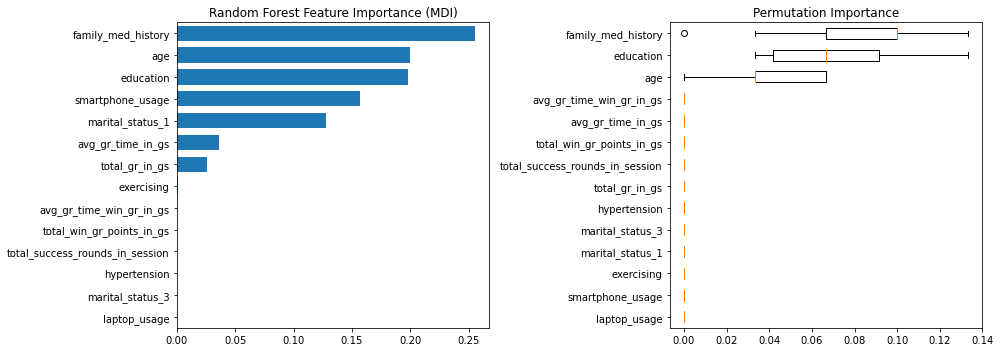

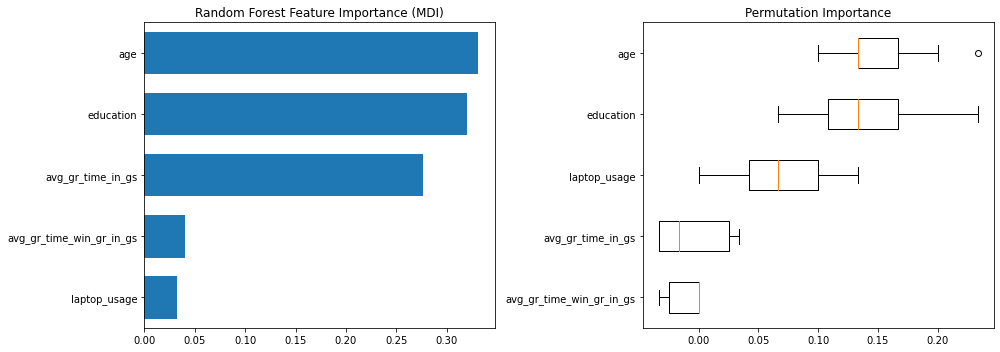

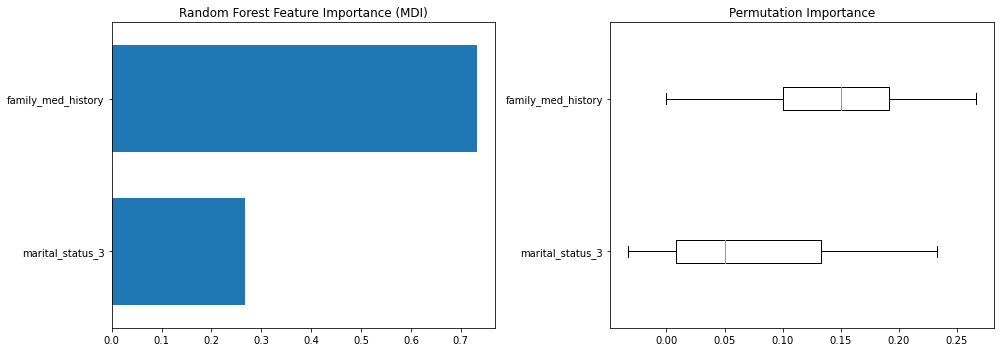

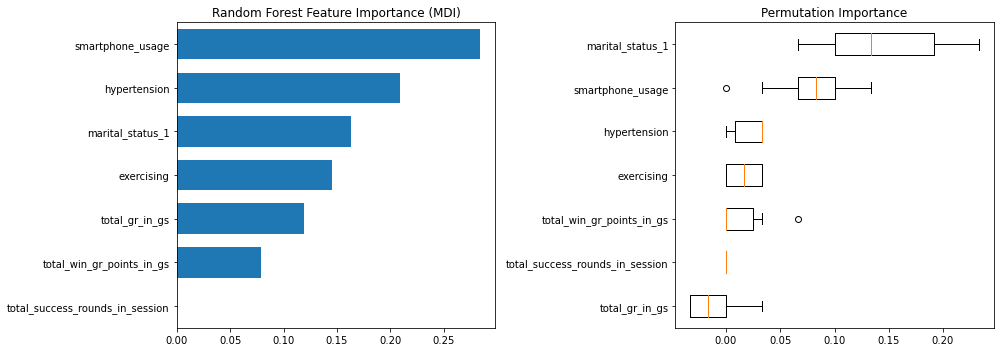

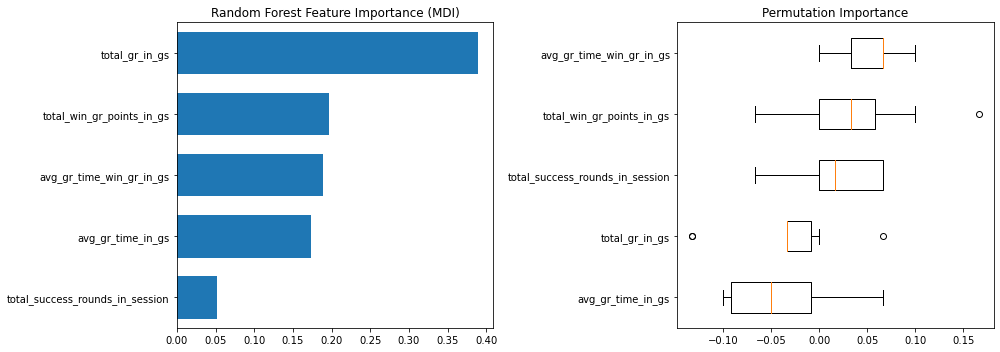

In [9]:
# feature importance inspection using a classifier
# MDI feature importance and feature values permutation importance

fm.inspection_using_classifier(df, all_features)
fm.inspection_using_classifier(df, cl1_features)
fm.inspection_using_classifier(df, cl2_features)
fm.inspection_using_classifier(df, cl3_features)
fm.inspection_using_classifier(df, session_features)

['total_win_gr_points_in_gs', 'avg_gr_time_in_gs']

<Figure size 432x288 with 0 Axes>

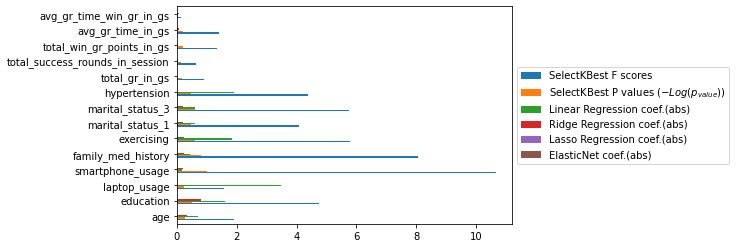

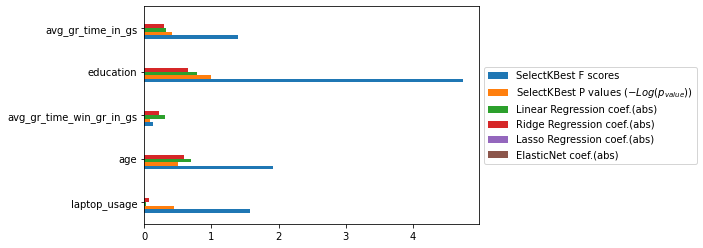

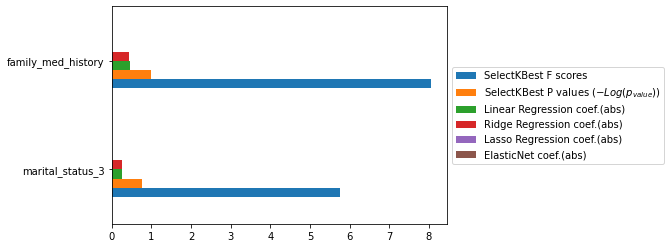

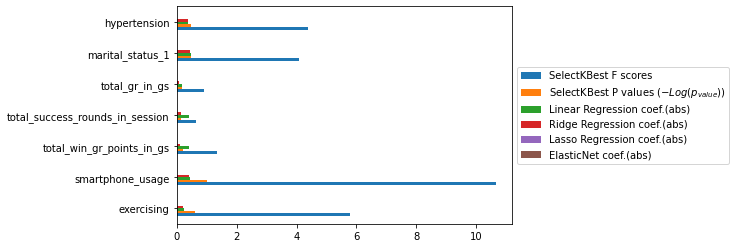

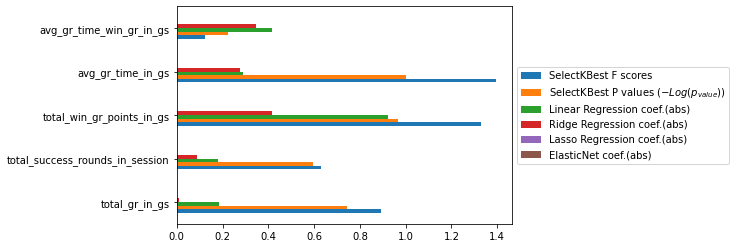

In [10]:
# Feature importance inspection using Univariate Feature Selection
# More specifically, ANOVA and some traditional Regressors
# TODO check also for the target as continuous  

fm.inspection_using_regressors(df, all_features)
fm.inspection_using_regressors(df, cl1_features)
fm.inspection_using_regressors(df, cl2_features)
fm.inspection_using_regressors(df, cl3_features)
fm.inspection_using_regressors(df, session_features)

In [11]:
# split dataframe samples for the training and evaluation process
selected_features = ['education', 'avg_gr_time_in_gs',
                     'total_gr_in_gs']
x = df[selected_features]
y = df.iloc[:, df.columns.get_loc('target_class')]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=7)

In [12]:
# train models
trained_models = train.train_models(x_train, y_train)

Total training time: 0.07 seconds


Metrics for  Logistic Regression
accuracy  Score: 80.000% Std.: 0.000%
precision  Score: 80.000% Std.: 0.000%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 88.889% Std.: 0.000%
############## 

Metrics for  Decision Tree
accuracy  Score: 90.000% Std.: 8.165%
precision  Score: 95.833% Std.: 5.893%
recall  Score: 91.667% Std.: 5.893%
f1  Score: 93.611% Std.: 5.107%
############## 

Metrics for  Random Forest
accuracy  Score: 93.333% Std.: 4.714%
precision  Score: 100.000% Std.: 0.000%
recall  Score: 91.667% Std.: 5.893%
f1  Score: 95.556% Std.: 3.143%
############## 

Metrics for  Support Vector Classifier
accuracy  Score: 96.667% Std.: 4.714%
precision  Score: 100.000% Std.: 0.000%
recall  Score: 95.833% Std.: 5.893%
f1  Score: 97.778% Std.: 3.143%
############## 

Metrics for  Custom Ensemble
accuracy  Score: 90.000% Std.: 8.165%
precision  Score: 95.833% Std.: 5.893%
recall  Score: 91.667% Std.: 5.893%
f1  Score: 93.611% Std.: 5.107%
############## 



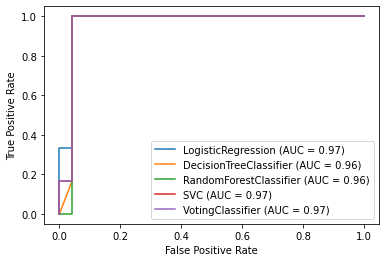

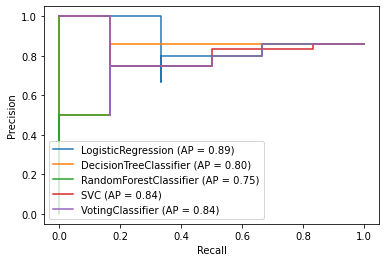

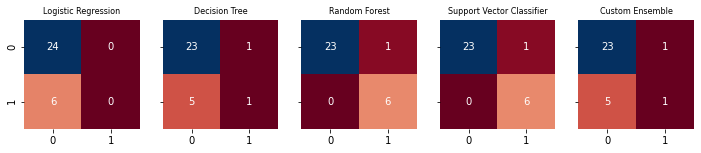

In [13]:
# evaluate models
# TODO print specificity
evaluate.generate_metrics(trained_models, x_test, y_test, ['accuracy', 'precision', 'recall', 'f1'], show_raw_data=False)